Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import randint, uniform
from sklearn.metrics import plot_confusion_matrix, classification_report

In [20]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
train, validate = train_test_split(train, random_state=42)
train.shape, validate.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

In [0]:
def data_wrangling(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


train = data_wrangling(train)
validate = data_wrangling(validate)
test = data_wrangling(test)

In [0]:
target = 'status_group'
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
X_train = train[features]
y_train = train[target]
X_validate = validate[features]
y_validate = validate[target]
X_test = test[features]

In [0]:
# PIPELINE TO MATCH 'RandomizedSearchCV' FROM YESTERDAY
pipeline = Pipeline([
    ('encoder', ce.OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', RandomForestClassifier(max_features=0.42044275299180944, 
                                     min_samples_leaf=3, 
                                     n_estimators=452, 
                                     random_state=42))
])

In [27]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_validate)
print(f'Train accuracy: {pipeline.score(X_train, y_train):.5f}')
print(f'Validation accuracy: {pipeline.score(X_validate, y_validate):.5f}')

Train accuracy: 0.91650
Validation accuracy: 0.80855


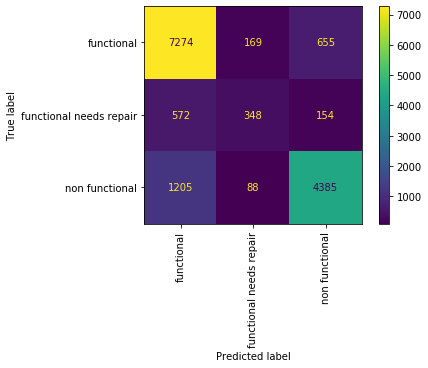

In [28]:
plot_confusion_matrix(pipeline, X_validate, y_validate, values_format='.0f', xticks_rotation='vertical');

In [29]:
print(classification_report(y_validate, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      8098
functional needs repair       0.58      0.32      0.41      1074
         non functional       0.84      0.77      0.81      5678

               accuracy                           0.81     14850
              macro avg       0.74      0.66      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



In [34]:
# REWATCH THIS

y_train = y_train != 'functional'
y_validate = y_validate != 'functional'
y_train.value_counts(normalize=True)

False    0.542334
True     0.457666
Name: status_group, dtype: float64

In [0]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_validate)

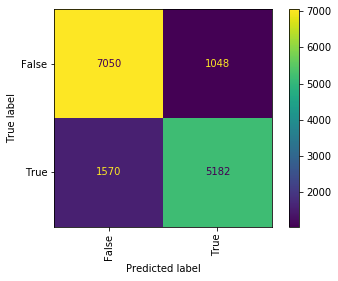

In [36]:
plot_confusion_matrix(pipeline, X_validate, y_validate, values_format='.0f', xticks_rotation='vertical');

In [41]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.87      0.84      8098
        True       0.83      0.77      0.80      6752

    accuracy                           0.82     14850
   macro avg       0.82      0.82      0.82     14850
weighted avg       0.82      0.82      0.82     14850



In [0]:
y_pred_proba = pipeline.predict_proba(X_validate)[:,1]

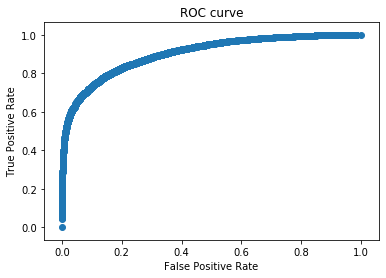

In [46]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_validate, y_pred_proba)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_validate, y_pred_proba)

0.903100854871427